# Clustering example

In [1]:
import os,sys
sys.path.append(os.path.realpath('../lib'))
import pylab as pl
import numpy as np
import ot
import FGW
from fgwclustering import FusedGromovWassersteinGraphKMeans
from graph import Graph
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import adjusted_mutual_info_score
from scipy.sparse.csgraph import shortest_path


In [2]:
np.random.seed(12)

In [3]:
#%% Heuristic to compute a adjency matrix from a C in R^n\times n
def sp_to_adjency(C,threshinf=0.2,threshsup=1.8):
    H=np.zeros_like(C)
    np.fill_diagonal(H,np.diagonal(C))
    C=C-H
    #C=stats.threshold(C, threshmin=threshinf, threshmax=threshsup, newval=0)
    C=np.minimum(np.maximum(C,threshinf),threshsup)
    C[C==threshsup]=0
    C[C!=0]=1   
    
    return C   
#%%
def find_thresh(C,inf=0.5,sup=3,step=10):
    dist=[]
    search=np.linspace(inf,sup,step)
    for thresh in search:
        Cprime=sp_to_adjency(C,0,thresh)
        #print(Cprime)
        SC=shortest_path(Cprime,method='D')
        SC[SC==float('inf')]=100
        #print(SC)
        dist.append(np.linalg.norm(SC-C))
    return search[np.argmin(dist)],dist

In [4]:
def build_comunity_graph(N=30,Nc=3,sigma=0.3,pw=0.8,pb=0.2):
    
    c=(Nc*np.arange(N)/N).astype(int)
    c2=(2*Nc*np.arange(N)/N).astype(int)
    v=c+1*np.mod(c2,2)+sigma*np.random.randn(N);
    g=Graph()
    g.add_nodes(list(range(N)))
    for i in range(N):
         g.add_one_attribute(i,v[i])
         for j in range(i+1,N):
             r=np.random.rand()
             #print(c[i],c[j],c[j]+1)
             if (c[i]==c[j]) or ((c[i]==c[j]-1) and r<pb): # or (c[i]==0 and c[j]==Nc)
                 g.add_edge((i,j))
          
    return g,v

In [5]:
def build_dataset(M=100):
    # X the list of community graphs
    # V the features
    # y the class
    X=[]
    y=[]
    V=[]
    all_N=[20,30,40]
    for i in range(M):
        for nc in [1,2,3,4]:
            n=np.random.choice(all_N)
            g,v=build_comunity_graph(N=n,Nc=nc,sigma=0.1,pw=0.7,pb=0.1)
            X.append(g)
            V.append(v)
            y.append(nc)
    return X,y,V

In [6]:
X,y,V=build_dataset(5)

<Figure size 432x288 with 0 Axes>

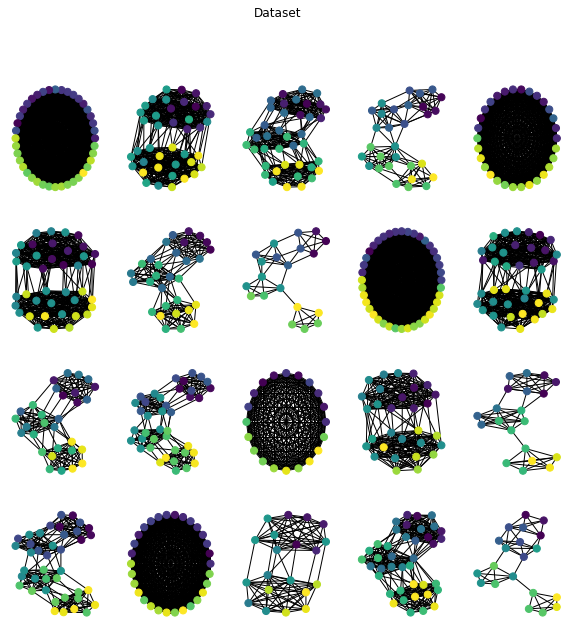

In [7]:
plt.clf()
plt.figure(10,figsize=(10,10))
k=1
for i in range(len(X)):
    plt.subplot(4,5,k)
    g=X[i]
    v=V[i]
    pos=nx.kamada_kawai_layout(g.nx_graph)
    nx.draw(g.nx_graph,pos=pos
            ,node_color = v
            ,vmin=v.min(),vmax=v.max()
            ,with_labels=False
           ,node_size=50)   
    k=k+1
plt.suptitle('Dataset')
plt.show()

In [8]:
connected=[]
for x in X:
    connected.append(nx.is_connected(x.nx_graph))

In [9]:
np.sum(connected)/len(connected)

1.0

In [10]:
# Precompute all the shortest path distances
for x in X:
    C=x.distance_matrix(method='shortest_path',force_recompute=True)

In [11]:
alpha=0.9997 # here the structure is more driving the classes
fgw_kmeans=FusedGromovWassersteinGraphKMeans(N=30,n_clusters=4,max_iter=15
                                             ,max_iter_barycenter=60,n_init=2
                                             ,metric_params={"alpha":alpha},verbose=1)

In [12]:
fgw_kmeans.fit(np.array(X))

Init 1
 Inertia : 0.837   -->   Inertia : 0.205   -->   Inertia : 0.230   -->   Inertia : 0.138   -->   Inertia : 0.138   -->  


In [13]:
adjusted_mutual_info_score(y,fgw_kmeans.labels_)

/usr/lib/python3/dist-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/lib/python3/dist-packages/sklearn/metrics/cluster/supervised.py:124: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


0.6854265751966778

In [14]:
features=fgw_kmeans._cluster_centers_features
structures=fgw_kmeans._cluster_centers_structure

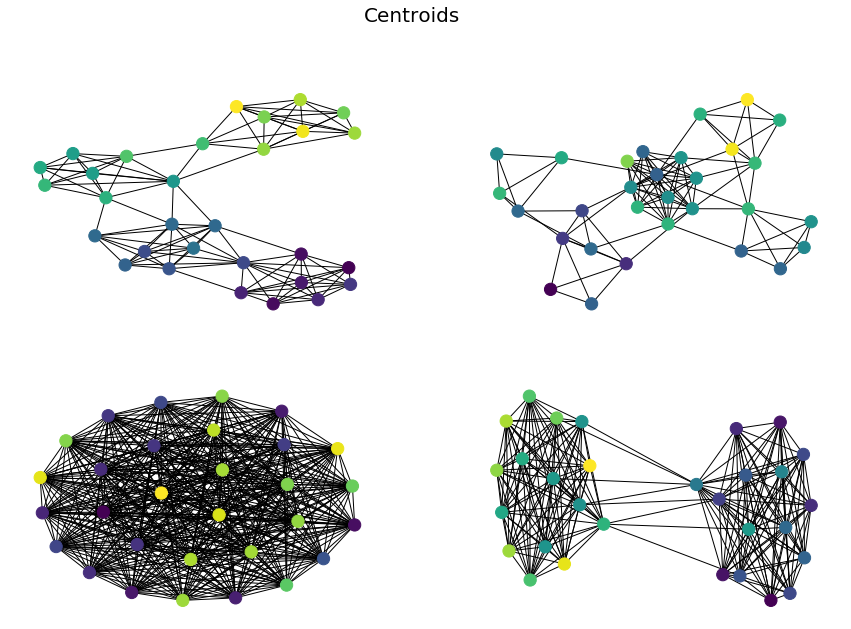

In [15]:
allbary=[]
for i in range(4):
    bary=nx.from_numpy_matrix(sp_to_adjency(structures[i]
                                            ,threshinf=0
                                            ,threshsup=find_thresh(structures[i],sup=1.5,step=150)[0]))
    for j in range(len(features[i])):
        bary.add_node(j,attr_name=float(features[i][j]))
    allbary.append(bary)
plt.figure(10,figsize=(15,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    if i in [0,1]:
        pos=nx.kamada_kawai_layout(allbary[i])
    elif i==3:
        pos=nx.spring_layout(allbary[i],scale=1.3,k=1)
    else:
        pos=nx.spring_layout(allbary[i],scale=2,k=0.8)
    nx.draw(allbary[i],pos=pos
            ,node_color = features[i].ravel()
            ,vmin=features[i].min(),vmax=features[i].max()
            ,with_labels=False
           ,node_size=150)
plt.suptitle('Centroids',fontsize=20)
plt.show()